# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [20]:
#Load your data into a pandas dataframe here

df = pd.read_csv("household_power_clean.zip")

In [21]:
#convert datetime to epoch/unix time
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')  # Ensure proper datetime parsing
df['unix'] = df['Datetime'].astype('int64') 

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: Ph is value for how many steps ahead of time the model can predict . Here  ph is set to 5 minutes and in dataset the data has 1 min interval .Hence the Ph = 5 <br>
<br>mu is the smoothing factor .It can change the behaviour of the time series model .Here it is given as ..9=90%.This means it will give 90% weightage to the data for the current observation.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [30]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #minutes
ph_index = 5 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:Almost zero .weight =(mu)^timesteps_away ..This means (0.9)^50000 approximatly equal to zero .

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [36]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[:i]
    ys_tmp = ys[:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] * (mu ** k)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = np.polyfit(ts_tmp.squeeze(), ys_tmp.squeeze(), 1, w=weights)
    model_tmp = np.poly1d(lm_tmp)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = lm_tmp[0]
    q_tmp = lm_tmp[1]

    #use ph to make the model prediction according to the prediction time
    
    tp = ts_tmp.iloc[-1].iloc[0] + ph_index  #
    yp = model_tmp(tp)
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

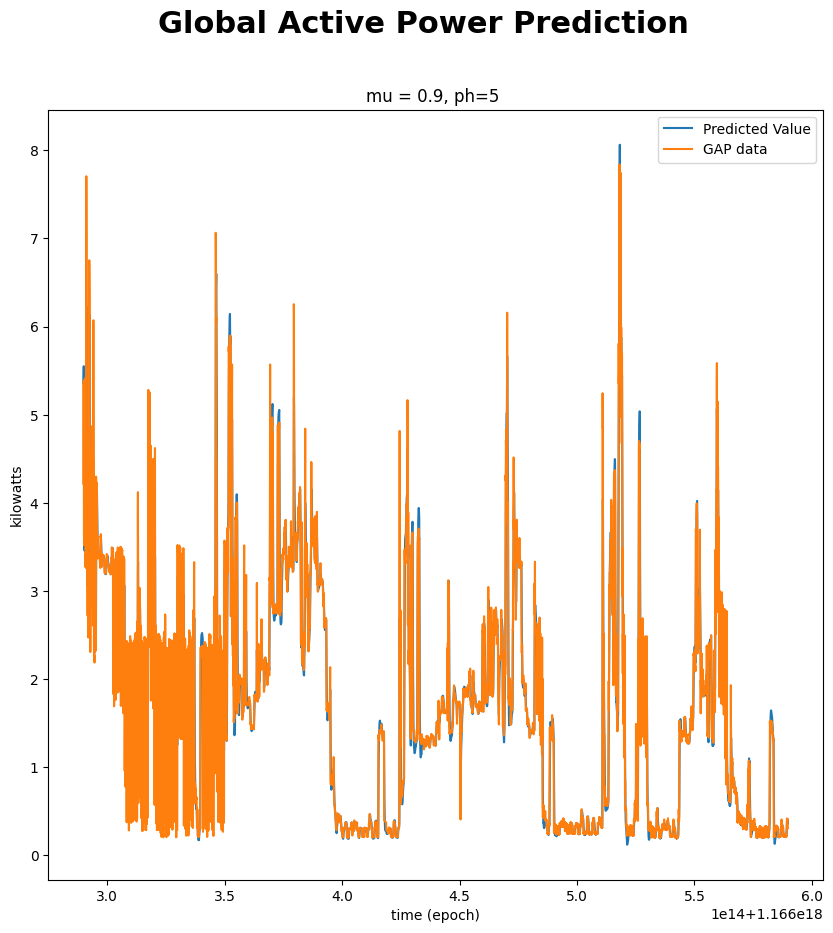

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

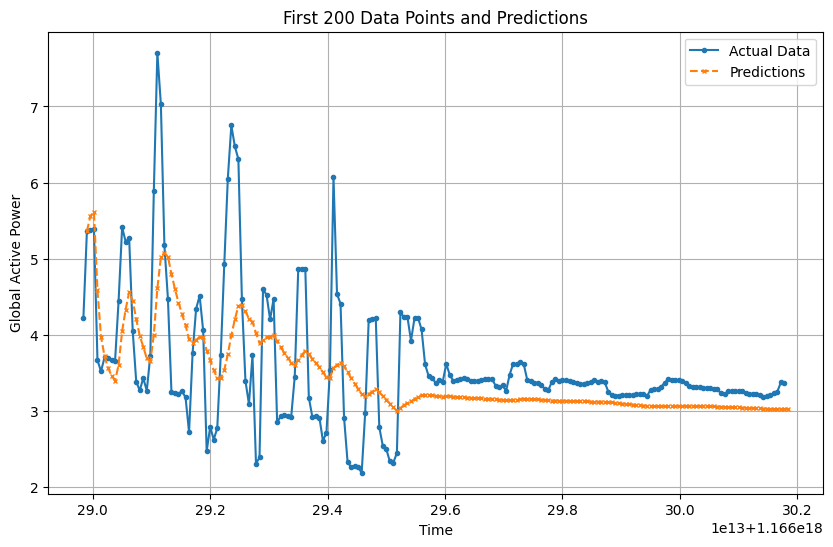

In [72]:

import matplotlib.pyplot as plt

n_points = 200

plt.figure(figsize=(10, 6))
plt.plot(ts[:n_points], ys[:n_points], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:n_points], yp_pred[:n_points], label="Predictions", marker='x', linestyle='--', markersize=3)
 
plt.title("First 200 Data Points and Predictions")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()

plt.show()

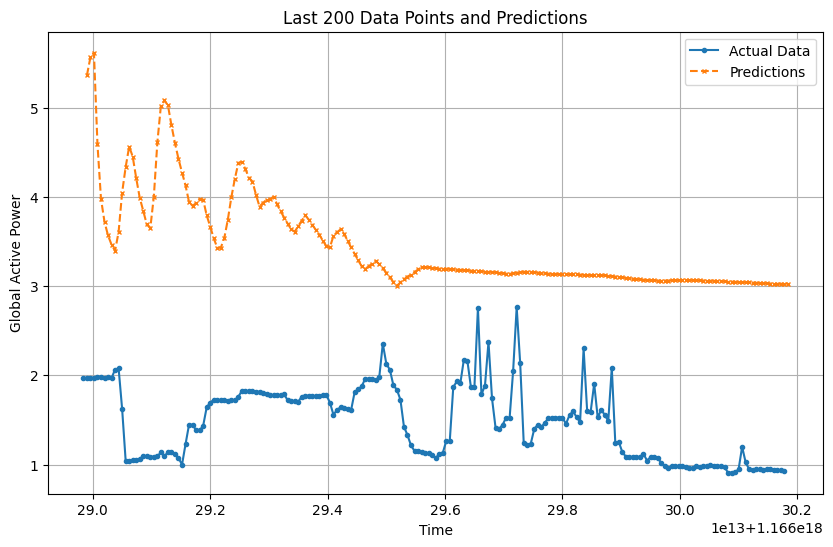

In [76]:
#Plot last 200 data points/predictions
n_points = 200

plt.figure(figsize=(10, 6))
plt.plot(ts[:n_points], ys[-n_points:], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:n_points], yp_pred[:n_points], label="Predictions", marker='x', linestyle='--', markersize=3)
 
plt.title("Last 200 Data Points and Predictions")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()

plt.show()

In [47]:

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
 
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred))


MSE is 0.4747854071677916


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Our model perfomed pretty good for the first 200 data points .The graph also indicates the same .But this is not true for the last 200 points .MSE is 0.474.This indicates that the model is good when the range of data is bigger .

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [52]:
#Re-run prediction code for mu = 1
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #minutes
ph_index = 5 #ph/data resolution (how many timesteps is our ph?)
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[:i]
    ys_tmp = ys[:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] * (mu ** k)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = np.polyfit(ts_tmp.squeeze(), ys_tmp.squeeze(), 1, w=weights)
    model_tmp = np.poly1d(lm_tmp)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = lm_tmp[0]
    q_tmp = lm_tmp[1]

    #use ph to make the model prediction according to the prediction time
    
    tp = ts_tmp.iloc[-1].iloc[0] + ph_index  #
    yp = model_tmp(tp)
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

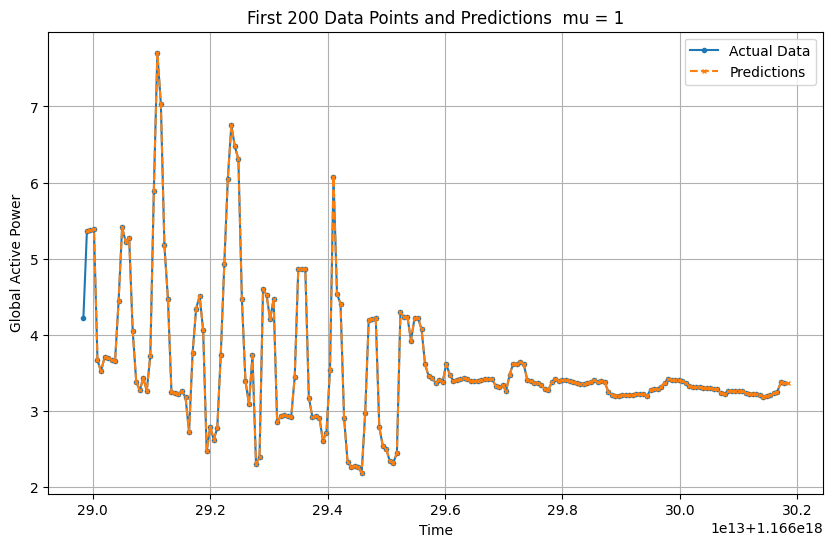

In [96]:
#Plot first 200 data points/predictions for mu = 1

n_points = 200

# Plot the actual data and predictions
plt.figure(figsize=(10, 6))
plt.plot(ts[:n_points], ys[:n_points], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:n_points], yp_pred[:n_points], label="Predictions", marker='x', linestyle='--', markersize=3)

# Add titles and labels
plt.title("First 200 Data Points and Predictions  mu = 1")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()

# Display the plot
plt.show()

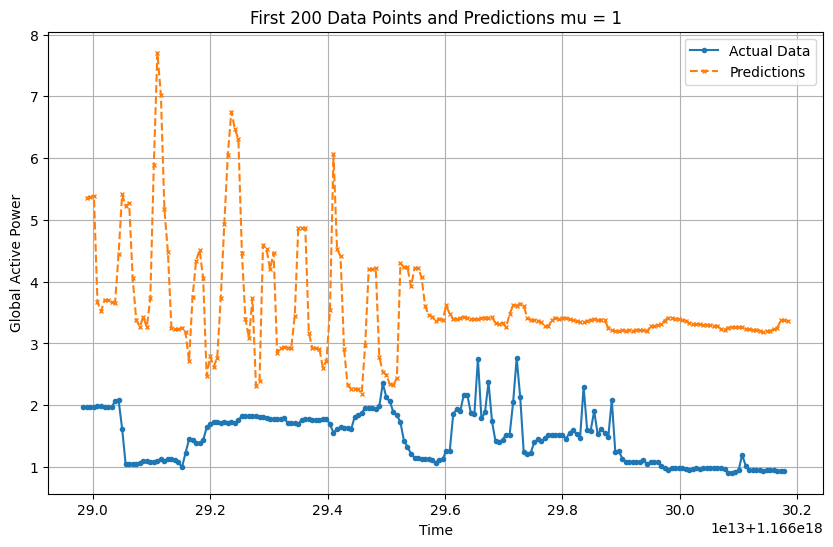

In [100]:
#Plot last 200 data points/predictions for mu = 1
n_points = 200

plt.figure(figsize=(10, 6))
plt.plot(ts[:n_points], ys[-n_points:], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:n_points], yp_pred[:n_points], label="Predictions", marker='x', linestyle='--', markersize=3)
 
plt.title("First 200 Data Points and Predictions mu = 1")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()

plt.show()

In [102]:
#Calculate MSE of predictions for mu = 1

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
 
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred))

MSE is 0.5701086471518324


In [88]:
#Re-run prediction code for mu = 0.01
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #minutes
ph_index = 5 #ph/data resolution (how many timesteps is our ph?)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[:i]
    ys_tmp = ys[:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] * (mu ** k)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = np.polyfit(ts_tmp.squeeze(), ys_tmp.squeeze(), 1, w=weights)
    model_tmp = np.poly1d(lm_tmp)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = lm_tmp[0]
    q_tmp = lm_tmp[1]

    #use ph to make the model prediction according to the prediction time
    
    tp = ts_tmp.iloc[-1].iloc[0] + ph_index  #
    yp = model_tmp(tp)
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

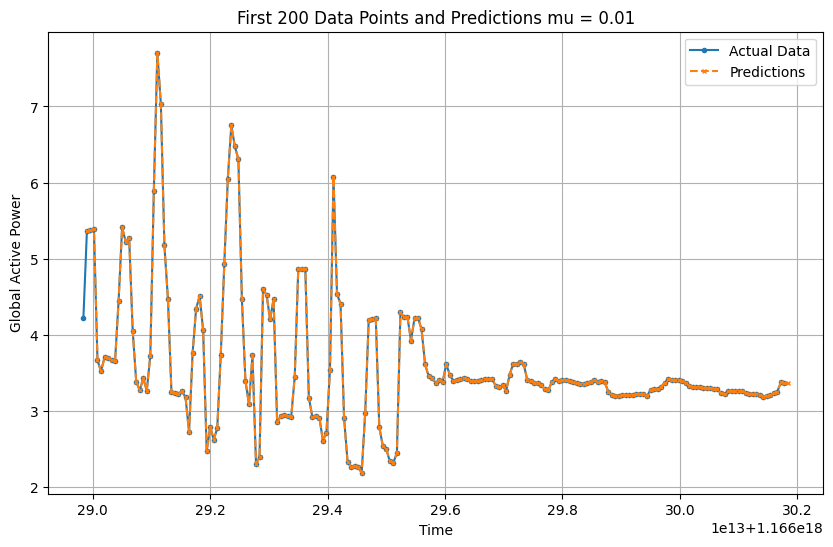

In [104]:
#Plot first 200 data points/predictions for mu = 0.01

n_points = 200

# Plot the actual data and predictions
plt.figure(figsize=(10, 6))
plt.plot(ts[:n_points], ys[:n_points], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:n_points], yp_pred[:n_points], label="Predictions", marker='x', linestyle='--', markersize=3)

# Add titles and labels
plt.title("First 200 Data Points and Predictions mu = 0.01")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()

# Display the plot
plt.show()

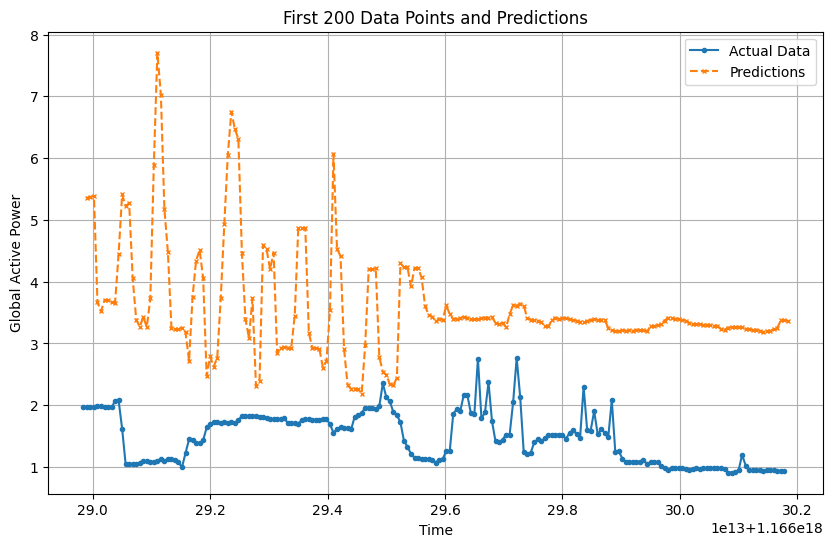

In [92]:
#Plot last 200 data points/predictions for mu = 0.01
n_points = 200

plt.figure(figsize=(10, 6))
plt.plot(ts[:n_points], ys[-n_points:], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:n_points], yp_pred[:n_points], label="Predictions", marker='x', linestyle='--', markersize=3)
 
plt.title("First 200 Data Points and Predictions mu = 0.01")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()

plt.show()

In [114]:
#Calculate MSE of predictions for mu = 0.01

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
 
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred))

MSE is 4.561000619318961


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A:  MSE=0.5701
The Mean Squared Error (MSE) indicates the average squared difference between the predicted and actual values.
A smaller MSE suggests better model performance. Here, the MSE is moderate, indicating that the model is capturing trends reasonably well but still has room for improvement.
In the later part of the dataset (second chart), predictions align much more closely with the actual values.
This is because, over time, the cumulative effect of having more data improves the linear regression model’s ability to generalize and follow the underlying trend.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: mu=0.01 perfomed better than all the other models

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: mu-0.01

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: We can try other values for MU

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [113]:
#add voltage to the x-variables in our dataset

ts = pd.DataFrame(df[['unix', 'Voltage']])  # Add Voltage as an additional variable
ys = pd.DataFrame(df.Global_active_power)

ph = 5  # minutes
ph_index = 5  # ph/data resolution (how many timesteps is our ph?)
mu = 0.9

# Limit the number of samples in the model to 5000 for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

# Re-run prediction code
for i in range(2, n_s + 1):  # Start out with 2 leading data points
    # Get x (time + voltage) and y data "available" for our prediction
    ts_tmp = ts[:i]
    ys_tmp = ys[:i]
    ns = len(ys_tmp)

    # Apply weights based on mu
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k] * (mu ** k)
    weights = np.flip(weights, 0)

    # Perform weighted linear regression on "available" data
    lm_tmp = np.linalg.lstsq(
        ts_tmp.values * weights[:, np.newaxis], ys_tmp.values * weights, rcond=None
    )[0]
    model_tmp = lambda x: np.dot(x, lm_tmp)  # Linear regression model

    # Use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1] + ph_index  # Ensure `tp` is a scalar or an array of features
    yp = model_tmp(tp)  # Model prediction
    # Use ph to make the model prediction according to the prediction time

# Store predictions
    tp_pred[i - 2] = ts_tmp.iloc[-1, 0]  # Only store the time (unix) for visualization
    yp_pred[i - 2] = yp[0]  # Extract the scalar value from the prediction array



In [117]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage



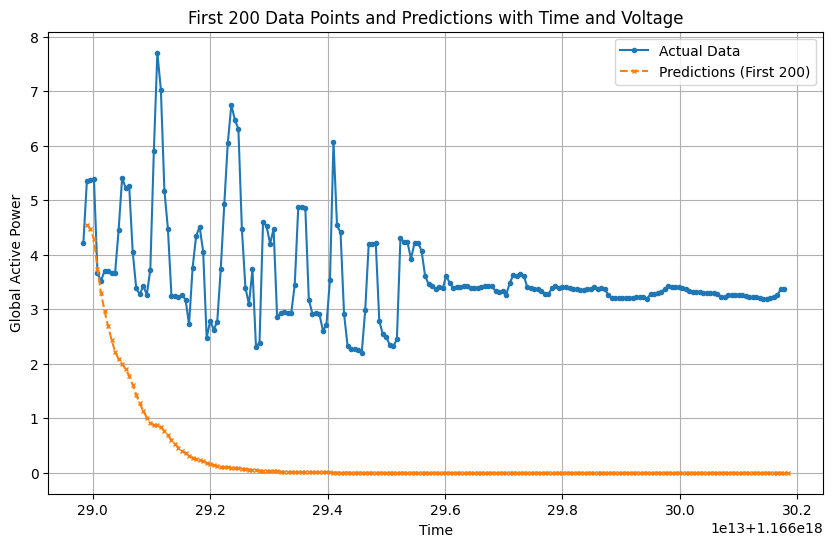

In [119]:
#Plot first 200 data points/predictions for the expanded dataset
# Visualize the first 200 points
plt.figure(figsize=(10, 6))
plt.plot(ts['unix'][:200], ys['Global_active_power'][:200], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:200], yp_pred[:200], label="Predictions (First 200)", linestyle='--', marker='x', markersize=3)
plt.title("First 200 Data Points and Predictions with Time and Voltage")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()
plt.show()

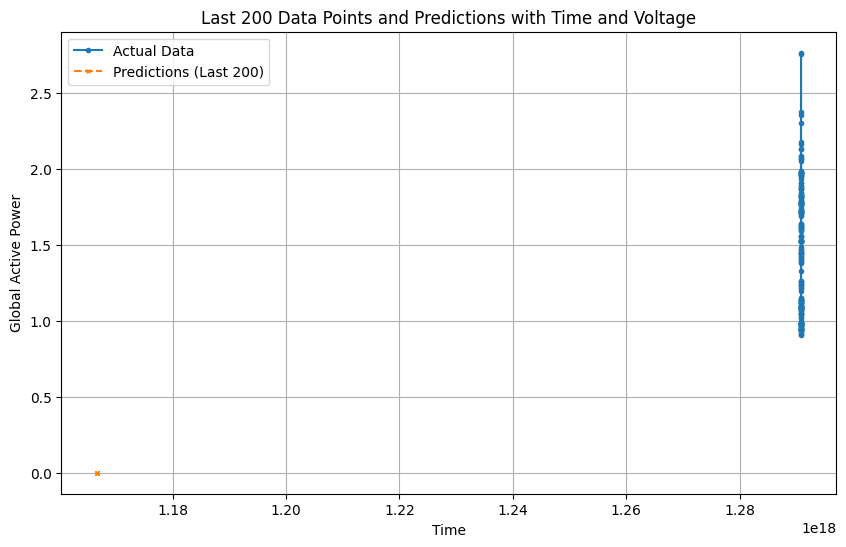

In [121]:
#Plot last 200 data points/predictions for the expanded data
plt.figure(figsize=(10, 6))
plt.plot(ts['unix'][-200:], ys['Global_active_power'][-200:], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[-200:], yp_pred[-200:], label="Predictions (Last 200)", linestyle='--', marker='x', markersize=3)
plt.title("Last 200 Data Points and Predictions with Time and Voltage")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()
plt.show()

In [125]:
#Calculate MSE of predictions for the expanded data

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
 
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred))

MSE is 4.561000619318961


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A:  voltage added unnecessary noise or irrelevant information.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: Will increase the smaple size to 10K ,ph_index=10 and mu=0.9

In [187]:
#create your alternative training data here


#Re-run prediction code for mu = 1
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 10 #minutes
ph_index = 10 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 10000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[:i]
    ys_tmp = ys[:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] * (mu ** k)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = np.polyfit(ts_tmp.squeeze(), ys_tmp.squeeze(), 1, w=weights)
    model_tmp = np.poly1d(lm_tmp)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = lm_tmp[0]
    q_tmp = lm_tmp[1]

    #use ph to make the model prediction according to the prediction time
    
    tp = ts_tmp.iloc[-1].iloc[0] + ph_index  #
    yp = model_tmp(tp)
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

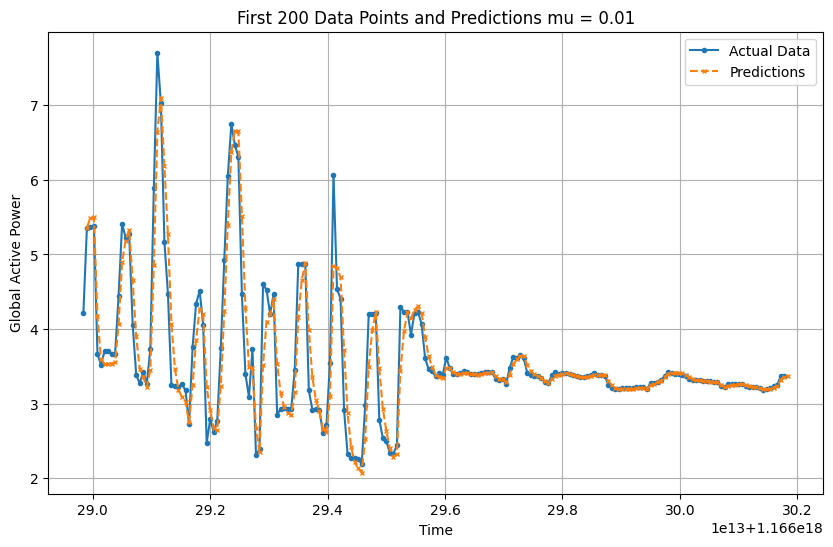

In [179]:
#re-run the prediction code here

n_points = 200

# Plot the actual data and predictions
plt.figure(figsize=(10, 6))
plt.plot(ts[:n_points], ys[:n_points], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:n_points], yp_pred[:n_points], label="Predictions", marker='x', linestyle='--', markersize=3)

# Add titles and labels
plt.title("First 200 Data Points and Predictions mu = 0.01")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()

# Display the plot
plt.show()

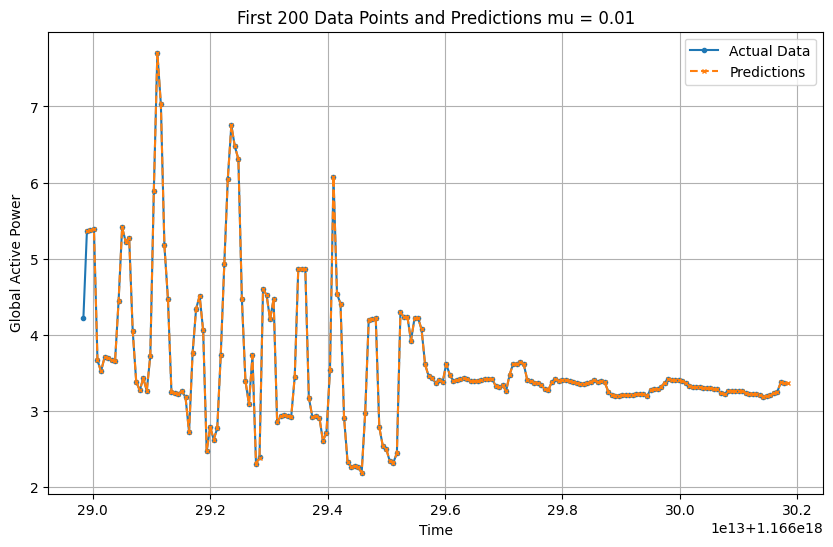

In [167]:
#Plot first 200 data points/predictions for alternative model

n_points = 200

# Plot the actual data and predictions
plt.figure(figsize=(10, 6))
plt.plot(ts[:n_points], ys[:n_points], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:n_points], yp_pred[:n_points], label="Predictions", marker='x', linestyle='--', markersize=3)

# Add titles and labels
plt.title("First 200 Data Points and Predictions mu = 0.01")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()

# Display the plot
plt.show()

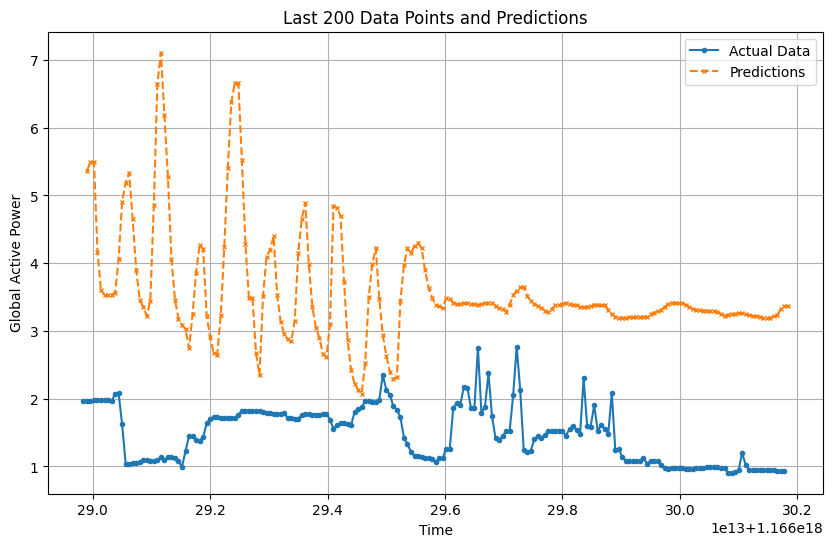

In [174]:
#Plot last 200 data points/predictions for alternative model



plt.figure(figsize=(10, 6))
plt.plot(ts[:n_points], ys[-n_points:], label="Actual Data", marker='o', linestyle='-', markersize=3)
plt.plot(tp_pred[:n_points], yp_pred[:n_points], label="Predictions", marker='x', linestyle='--', markersize=3)
 
plt.title("Last 200 Data Points and Predictions")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid()

In [184]:
#Calculate MSE of predictions for alternative model
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
 
print("MSE is", mse(ys['Global_active_power'][ph_index:10000+ph_index-1], yp_pred))

MSE is 0.4660513267809929


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.